<a href="https://colab.research.google.com/github/fedhere/PUS2020_FBianco/blob/master/classdemo/PUS2020_autoenc_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for PUS2020

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [29]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [31]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [57]:
cd /content/gdrive/Shareddrives///


/content/gdrive/Shareddrives


In [58]:
ls

 bogcl/     FFTPCA/        MLTSA2020/    PUS2020/   RubinOLSSTPixelLevelTF/
 ChimeDE/   lightEchoes/   NSFDSC2021/   pyboot/   'UD COVID19 Hackathon'/


In [59]:
cd  PUS2020/

/content/gdrive/Shareddrives/PUS2020


# 1A load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip

--2020-12-07 18:01:48--  http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip
Resolving www.cl.cam.ac.uk (www.cl.cam.ac.uk)... 128.232.0.20, 2a05:b400:110::80:14
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip [following]
--2020-12-07 18:01:48--  https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip [following]
--2020-12-07 18:01:48--  https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip
Reusing existing connection to www.cl.cam.ac.uk:443.
HTTP request sent, awaiting response... 404 Not Found
2020-12-07 18:01:48 ERROR 404: Not Found.



In [ ]:
#!unzip faces95.zip

unzip:  cannot find or open faces95.zip, faces95.zip.zip or faces95.zip.ZIP.


In [61]:
!ls data/faces95/*jpg

data/faces95/adhast.10.jpg  data/faces95/sgjday.12.jpg
data/faces95/adhast.11.jpg  data/faces95/sgjday.13.jpg
data/faces95/adhast.12.jpg  data/faces95/sgjday.14.jpg
data/faces95/adhast.13.jpg  data/faces95/sgjday.15.jpg
data/faces95/adhast.14.jpg  data/faces95/sgjday.16.jpg
data/faces95/adhast.15.jpg  data/faces95/sgjday.17.jpg
data/faces95/adhast.16.jpg  data/faces95/sgjday.18.jpg
data/faces95/adhast.17.jpg  data/faces95/sgjday.19.jpg
data/faces95/adhast.18.jpg  data/faces95/sgjday.1.jpg
data/faces95/adhast.19.jpg  data/faces95/sgjday.20.jpg
data/faces95/adhast.1.jpg   data/faces95/sgjday.2.jpg
data/faces95/adhast.20.jpg  data/faces95/sgjday.3.jpg
data/faces95/adhast.2.jpg   data/faces95/sgjday.4.jpg
data/faces95/adhast.3.jpg   data/faces95/sgjday.5.jpg
data/faces95/adhast.4.jpg   data/faces95/sgjday.6.jpg
data/faces95/adhast.5.jpg   data/faces95/sgjday.7.jpg
data/faces95/adhast.6.jpg   data/faces95/sgjday.8.jpg
data/faces95/adhast.7.jpg   data/faces95/sgjday.9.jpg
data/faces95/adhast

In [62]:
flist = glob.glob("data/faces95/*jpg")

In [63]:
N = len(flist)
N

516


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

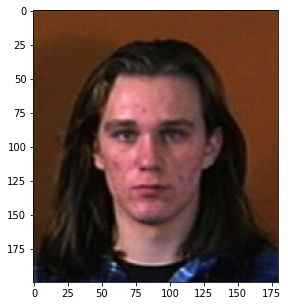

In [67]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

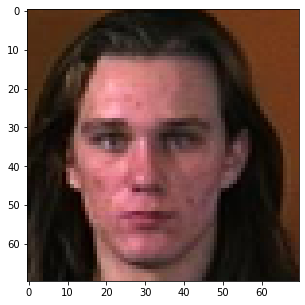

In [69]:
pl.imshow(np_im[25:165:2,25:165:2])

In [15]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
imgs = np.zeros((N, 70, 70, 1))
for i,f in enumerate(flist):
  if not i%50: print(i)
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
np.save("faces.npy", imgs)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400


# 1B you can read the images below if you have saved them earlier

In [71]:
imgs = np.load("data/faces.npy")
imgs.shape

(1440, 70, 70, 1)

## 2 lower the resolution#
make a copy of the original before you lower the res 

In [72]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [73]:
# lower the resolution
imgs = imgs[:,::2,::2]
imgs[0].shape

(35, 35, 1)

In [74]:
imgs.shape

(1440, 35, 35, 1)

In [75]:
#this is the number of pixels in the image
np.prod(imgs[0].shape)

1225

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [76]:
SUPERRESOLVE = True

In [77]:
from sklearn.model_selection import train_test_split
if SUPERRESOLVE:
  X_tr,  X_te, y_tr, y_te = train_test_split(imgs, imgs_orig, 
                                             test_size = .25, random_state=1)
else:
  X_tr,  X_te, y_tr, y_te = train_test_split(imgs, imgs, 
                                             test_size = .25, random_state=1)
  

In [78]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1080, 35, 35, 1), (360, 35, 35, 1), (1080, 70, 70, 1), (360, 70, 70, 1))

In [79]:
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [80]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1080, 1225), (360, 1225), (1080, 4900), (360, 4900))

## 3 build an autoencoder model

In [81]:
def create_model(bottleneck=128, input_dim=1225):
  model = Sequential()
  model.add(Dense(256, activation='relu', input_dim=1225))
  model.add(Dense(128, activation='relu', name="bottleneck"))
  if bottleneck < 128:
    model.add(Dense(bottleneck, activation='relu'))
    model.add(Dense(128, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1225, activation='relu'))
  model.add(Dense(1225*4, activation='sigmoid'))
  model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")
  return model
model = create_model()

In [82]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               313856    
_________________________________________________________________
bottleneck (Dense)           (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 1225)              314825    
_________________________________________________________________
dense_11 (Dense)             (None, 4900)              6007400   
Total params: 6,702,001
Trainable params: 6,702,001
Non-trainable params: 0
_________________________________________________________________
None


## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [28]:
# you can skip this and load the saved model
history = model.fit(X_tr, y_tr, epochs=100000, batch_size=16, verbose=1)
model.save("imgreconstruct_100000PUS.h5")

Epoch 1/100000
68/68 [==============================] - 0s 5ms/step - loss: 0.0416 - mae: 0.1605 - acc: 0.0000e+00
Epoch 2/100000
68/68 [==============================] - 0s 4ms/step - loss: 0.0289 - mae: 0.1308 - acc: 0.0019
Epoch 3/100000
68/68 [==============================] - 0s 4ms/step - loss: 0.0217 - mae: 0.1118 - acc: 9.2593e-04
Epoch 4/100000
68/68 [==============================] - 0s 4ms/step - loss: 0.0190 - mae: 0.1037 - acc: 0.0019
Epoch 5/100000
68/68 [==============================] - 0s 4ms/step - loss: 0.0171 - mae: 0.0975 - acc: 0.0000e+00
Epoch 6/100000
68/68 [==============================] - 0s 4ms/step - loss: 0.0156 - mae: 0.0921 - acc: 0.0019
Epoch 7/100000
68/68 [==============================] - 0s 5ms/step - loss: 0.0141 - mae: 0.0866 - acc: 0.0000e+00
Epoch 8/100000
68/68 [==============================] - 0s 4ms/step - loss: 0.0130 - mae: 0.0826 - acc: 0.0019
Epoch 9/100000
68/68 [==============================] - 0s 4ms/step - loss: 0.0119 - mae: 0.0784

KeyboardInterrupt: ignored

In [83]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
model.load_weights("data/imgreconstruct_10000.h5")

## predict

In [84]:
outim = model.predict(X_te)
outim

array([[0.23803368, 0.23000248, 0.23300679, ..., 0.14008921, 0.11853015,
        0.09816667],
       [0.30023423, 0.30895784, 0.303142  , ..., 0.2479376 , 0.24314575,
        0.25033206],
       [0.23010811, 0.2288801 , 0.23590074, ..., 0.15398994, 0.1522227 ,
        0.15035805],
       ...,
       [0.19341277, 0.20078753, 0.2073016 , ..., 0.02736585, 0.03827281,
        0.06948686],
       [0.37431017, 0.36125186, 0.35353535, ..., 0.23280121, 0.22780858,
        0.24385817],
       [0.28940883, 0.29232332, 0.29830796, ..., 0.03155717, 0.03212669,
        0.0318376 ]], dtype=float32)

In [85]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


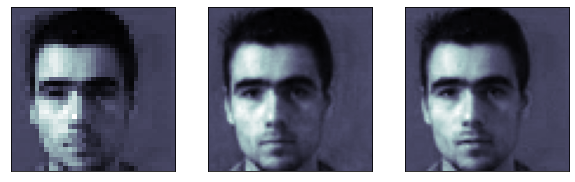

2 :	input		      prediction		  target


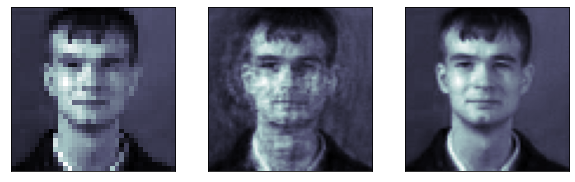

3 :	input		      prediction		  target


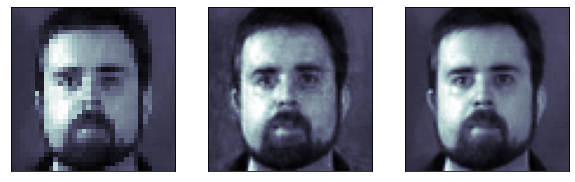

4 :	input		      prediction		  target


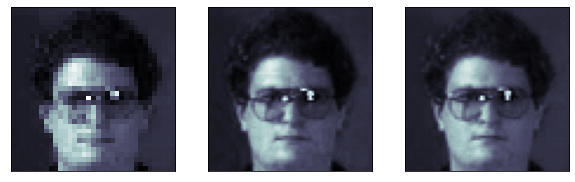

5 :	input		      prediction		  target


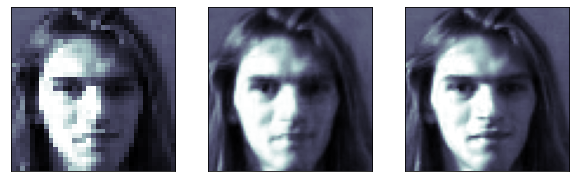

6 :	input		      prediction		  target


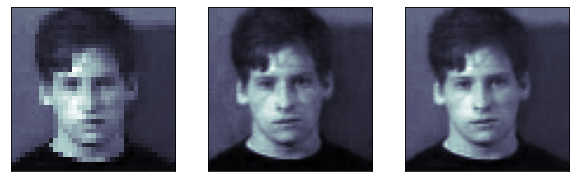

7 :	input		      prediction		  target


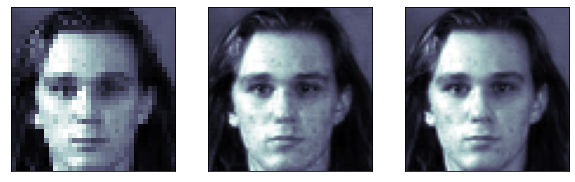

8 :	input		      prediction		  target


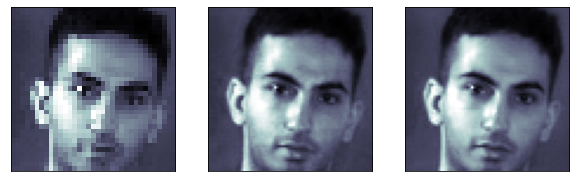

9 :	input		      prediction		  target


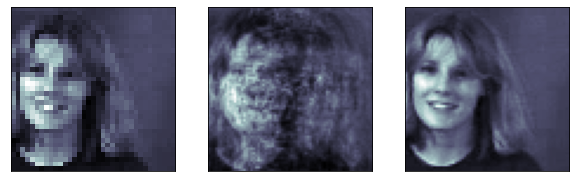

10 :	input		      prediction		  target


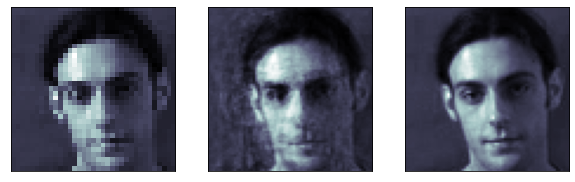

In [86]:
np.random.seed(123)
# pick a few random test images
for i in range(10):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

## show the latent representation of the data: the bottleneck layer output

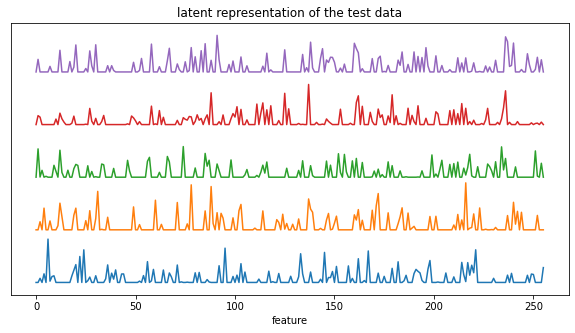

In [87]:
from keras import backend as K
# input placeholder
inp = model.input                   
# extract the bottle neck outputs
outputs = model.layers[2].output     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])    

# Testing
layer_outs = functors(X_te[:5])
  
for i in range(5):
  pl.plot(layer_outs[0][i] + i)

pl.xlabel("feature")
pl.yticks([],"")
pl.title("latent representation of the test data");

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [ ]:
imme = Image.open("data/testimg.png")

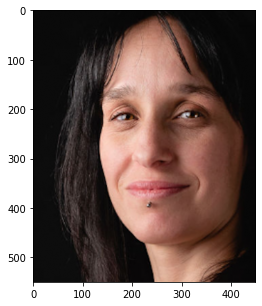

In [53]:

np_im = numpy.array(imme)[:,:,:3].astype(float) / 255
pl.figure()
pl.imshow(np_im[50:600,250:700,:] )
np_im[100:625,250:775,:].shape, np.prod(np_im.shape[1:]);


low resolution version
subsampling by 15

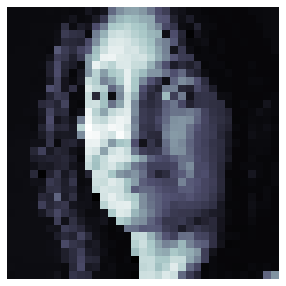

In [54]:
np_im_me = np_im[100:625,250:775,:][::15,::15,1]
pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

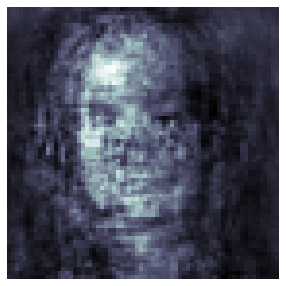

In [55]:
pl.imshow(model.predict(np.array([np_im_me.flatten()])).reshape(70,70), 
          cmap="bone")
pl.axis('off');

# ... not good at all :-( why??